In [1]:
import torch
from torchvision import transforms
from PIL import Image, ImageOps, ImageEnhance  
import os 
import random
from datasets import CustomImageDataset
from utils import show_images, show_single_augmentation, show_multiple_augmentations
from extra_augs import (AddGaussianNoise, RandomErasingCustom, CutOut, 
                       Solarize, Posterize, AutoContrast, ElasticTransform)
from collections import defaultdict

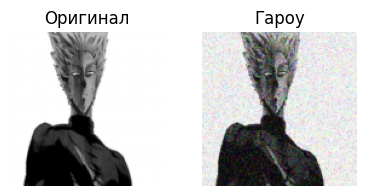

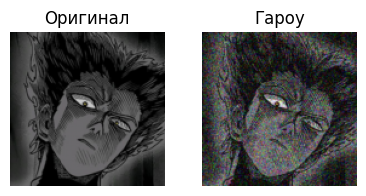

In [2]:
root = os.path.abspath("E:/vscode files/lab5/data/train")
dataset = CustomImageDataset(root, transform=None, target_size=(224, 224))

class SimpleGaussianNoise:
    """Добавляет простой гауссов шум"""
    def __init__(self, intensity=0.05):
        self.intensity = intensity
    
    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.intensity
        return torch.clamp(tensor + noise, 0, 1)

class BasicRandomErase:
    """Простое случайное стирание"""
    def __init__(self, erase_prob=0.5, erase_size=0.2):
        self.erase_prob = erase_prob
        self.erase_size = erase_size
    
    def __call__(self, img):
        if random.random() > self.erase_prob:
            return img
            
        c, h, w = img.shape
        erase_h = int(h * self.erase_size)
        erase_w = int(w * self.erase_size)
        
        x = random.randint(0, w - erase_w)
        y = random.randint(0, h - erase_h)
        
        img[:, y:y+erase_h, x:x+erase_w] = 0
        return img

class AdjustContrast:
    """Простая регулировка контраста"""
    def __init__(self, contrast_factor=1.2):
        self.contrast_factor = contrast_factor
    
    def __call__(self, img):
        img_pil = transforms.ToPILImage()(img)
        img_pil = ImageEnhance.Contrast(img_pil).enhance(self.contrast_factor)
        return transforms.ToTensor()(img_pil)
    
os.makedirs("results_2task", exist_ok=True)

pipeline = transforms.Compose([transforms.ToTensor(),AdjustContrast(1.1), BasicRandomErase(0.2),SimpleGaussianNoise(0.2)])

img1, label1 = dataset[0]
img2, label2 = dataset[1]

# Применяем аугментации
aug_img1 = pipeline(img1)
aug_img2 = pipeline(img2)
show_multiple_augmentations(
    img1,
    augmented_imgs=[aug_img1],
    titles=[dataset.classes[label1]],
    save_path=os.path.join("results_2task", f'{dataset.classes[label1]}_1.png')
)
show_multiple_augmentations(
    img2,
    augmented_imgs=[aug_img2],
    titles=[dataset.classes[label2]],
    save_path=os.path.join("results_2task", f'{dataset.classes[label1]}_2.png')
)




{'0': 30, '1': 30, '2': 30, '3': 30, '4': 30, '5': 30}
Статистика размеров изображений:
Минимальный размер: 210x240
Максимальный размер: 736x1308
Средний размер: 539x624


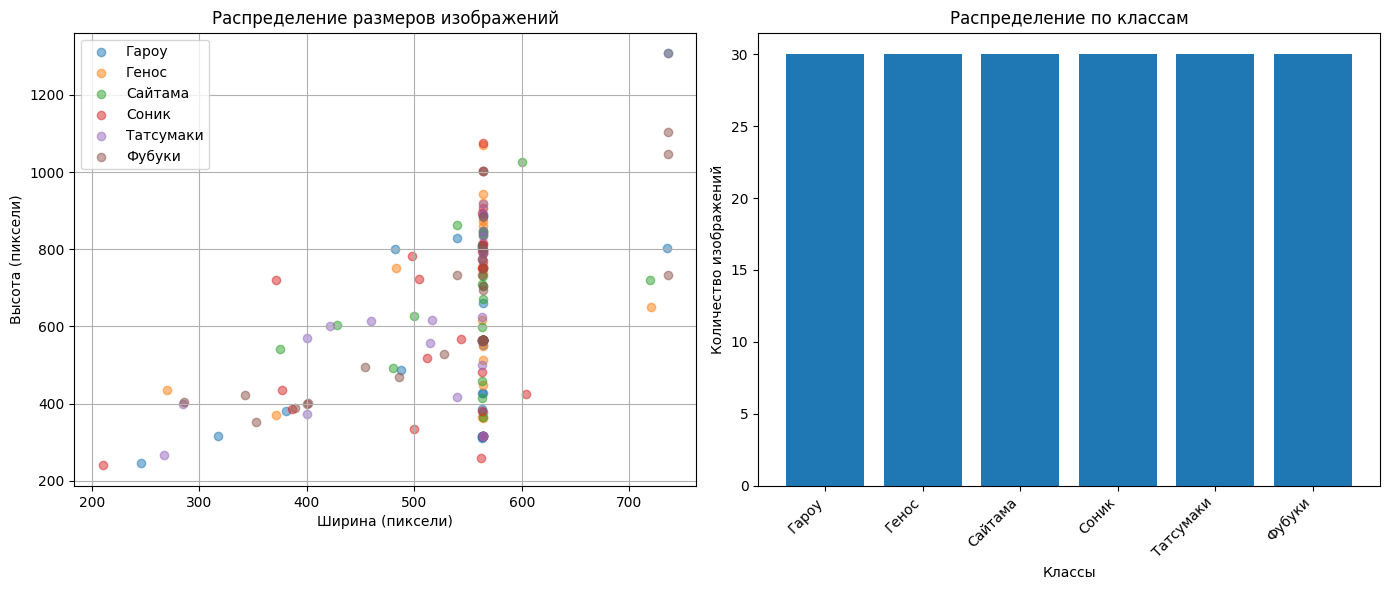

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

dictlabel = {'0':dataset.labels.count(0),
             '1':dataset.labels.count(1),
             '2':dataset.labels.count(2),
             '3':dataset.labels.count(3),
             '4':dataset.labels.count(4),
             '5':dataset.labels.count(5)
             }
print(dictlabel)

def analyze_dataset(dataset):
    # 1. Сбор статистики по размерам и классам
    size_stats = defaultdict(list)
    class_counts = defaultdict(int)
    
    for img_path, label in zip(dataset.images, dataset.labels):
        with Image.open(img_path) as img:
            width, height = img.size
            class_name = dataset.classes[label]
            size_stats[class_name].append((width, height))
            class_counts[class_name] += 1
    
    # 2. Расчет общей статистики размеров
    all_sizes = [size for class_sizes in size_stats.values() for size in class_sizes]
    widths, heights = zip(*all_sizes) if all_sizes else ([], [])
    
    print("Статистика размеров изображений:")
    if widths and heights:
        print(f"Минимальный размер: {min(widths)}x{min(heights)}")
        print(f"Максимальный размер: {max(widths)}x{max(heights)}")
        print(f"Средний размер: {np.mean(widths):.0f}x{np.mean(heights):.0f}")
    else:
        print("Нет данных для анализа")

    # 3. Визуализация
    plt.figure(figsize=(14, 6))
    
    # График распределения размеров
    plt.subplot(1, 2, 1)
    for class_name, sizes in size_stats.items():
        if sizes:  # Проверка на наличие данных
            widths, heights = zip(*sizes)
            plt.scatter(widths, heights, alpha=0.5, label=class_name)
    plt.xlabel('Ширина (пиксели)')
    plt.ylabel('Высота (пиксели)')
    plt.title('Распределение размеров изображений')
    plt.grid(True)
    plt.legend()
    
    # Гистограмма по классам
    plt.subplot(1, 2, 2)
    if class_counts:
        plt.bar(class_counts.keys(), class_counts.values())
        plt.xlabel('Классы')
        plt.ylabel('Количество изображений')
        plt.title('Распределение по классам')
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

analyze_dataset(dataset)


Конфигурация 1: ['flip', 'brightness']


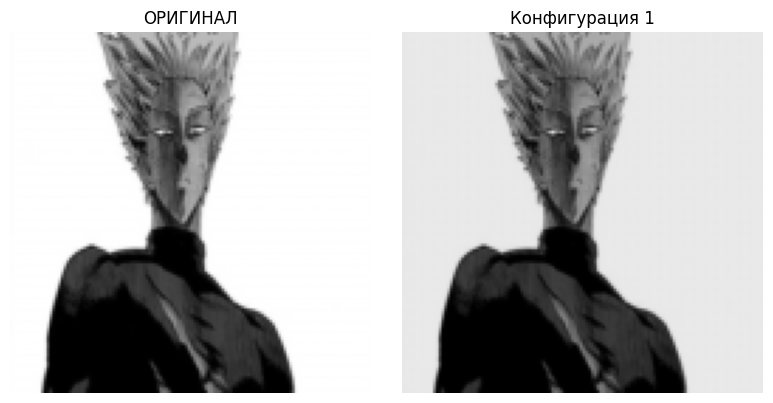


Конфигурация 2: ['flip', 'color', 'rotate']


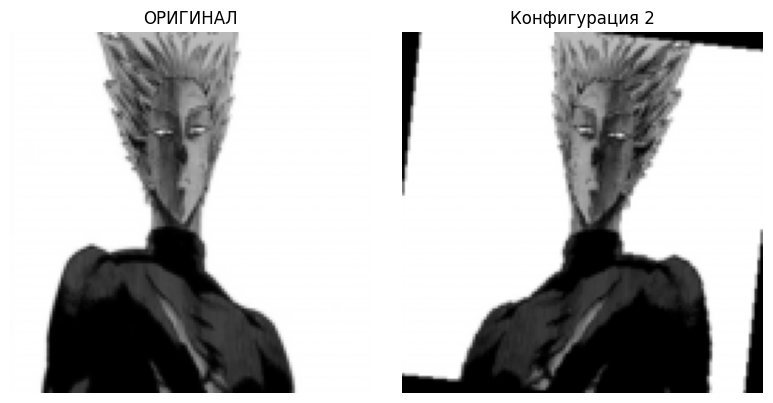


Конфигурация 3: ['flip', 'color', 'rotate', 'grayscale']


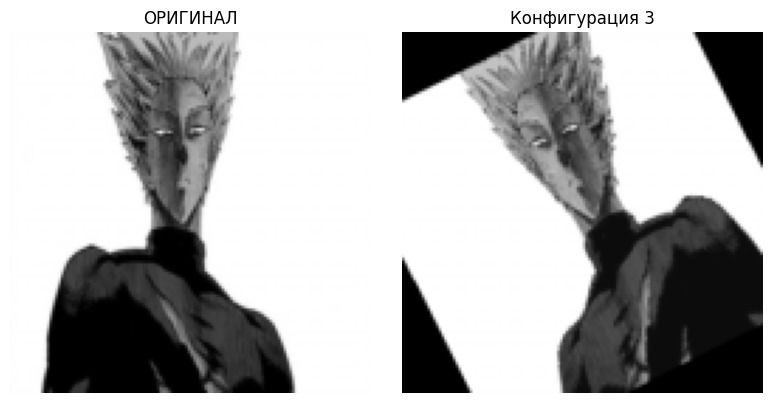

In [5]:
class AugmentationPipeline:
    def __init__(self):
        self.augmentations = {}  # Простой словарь для хранения аугментаций
        
    def add_augmentation(self, name, augmentation):
        """Добавляет аугментацию в пайплайн"""
        self.augmentations[name] = augmentation
        
    def remove_augmentation(self, name):
        """Удаляет аугментацию по имени"""
        if name in self.augmentations:
            del self.augmentations[name]
            
    def apply(self, image):
        """Применяет все аугментации последовательно"""
        for aug_name in self.augmentations:
            image = self.augmentations[aug_name](image)
        return image
        
    def get_augmentations(self):
        """Возвращает список имен аугментаций"""
        return list(self.augmentations.keys())

# Создаем конфигурации аугментаций
def setup_configurations():
    # Легкие аугментации
    light = AugmentationPipeline()
    light.add_augmentation("flip", transforms.RandomHorizontalFlip(p=0.3))
    light.add_augmentation("brightness", transforms.ColorJitter(brightness=0.1))
    
    # Средние аугментации
    medium = AugmentationPipeline()
    medium.add_augmentation("flip", transforms.RandomHorizontalFlip(p=1))
    medium.add_augmentation("color", transforms.ColorJitter(brightness=0.2, contrast=0.1))
    medium.add_augmentation("rotate", transforms.RandomRotation(15))
    
    # Сильные аугментации
    heavy = AugmentationPipeline()
    heavy.add_augmentation("flip", transforms.RandomHorizontalFlip(p=1))
    heavy.add_augmentation("color", transforms.ColorJitter(brightness=0.3, contrast=0.2))
    heavy.add_augmentation("rotate", transforms.RandomRotation(30))
    heavy.add_augmentation("grayscale", transforms.RandomGrayscale(p=0.3))
    
    return [light,  medium, heavy]

aug_pipelines = setup_configurations()

# Тестируем на первом изображении из датасета
image, label = dataset[0]

# Применяем все конфигурации аугментаций
for i, pipeline in enumerate(aug_pipelines):
        aug_image = pipeline.apply(image)  # Используем метод apply, а не вызываем объект напрямую
        print(f"\nКонфигурация {i+1}: {pipeline.get_augmentations()}")
        show_single_augmentation(
                original_img=image,
                augmented_img=aug_image,
                title=f"Конфигурация {i+1}"
            )




=== Размер 64x64 ===


Обработка 64x64: 100%|██████████| 100/100 [00:00<00:00, 150.19it/s]


Среднее время: 0.67 сек
Средняя память: 0.45 MB

=== Размер 128x128 ===


Обработка 128x128: 100%|██████████| 100/100 [00:00<00:00, 116.84it/s]


Среднее время: 0.87 сек
Средняя память: 0.33 MB

=== Размер 224x224 ===


Обработка 224x224: 100%|██████████| 100/100 [00:00<00:00, 100.48it/s]


Среднее время: 1.01 сек
Средняя память: 0.01 MB

=== Размер 512x512 ===


Обработка 512x512: 100%|██████████| 100/100 [00:02<00:00, 46.81it/s]


Среднее время: 2.03 сек
Средняя память: 2.62 MB


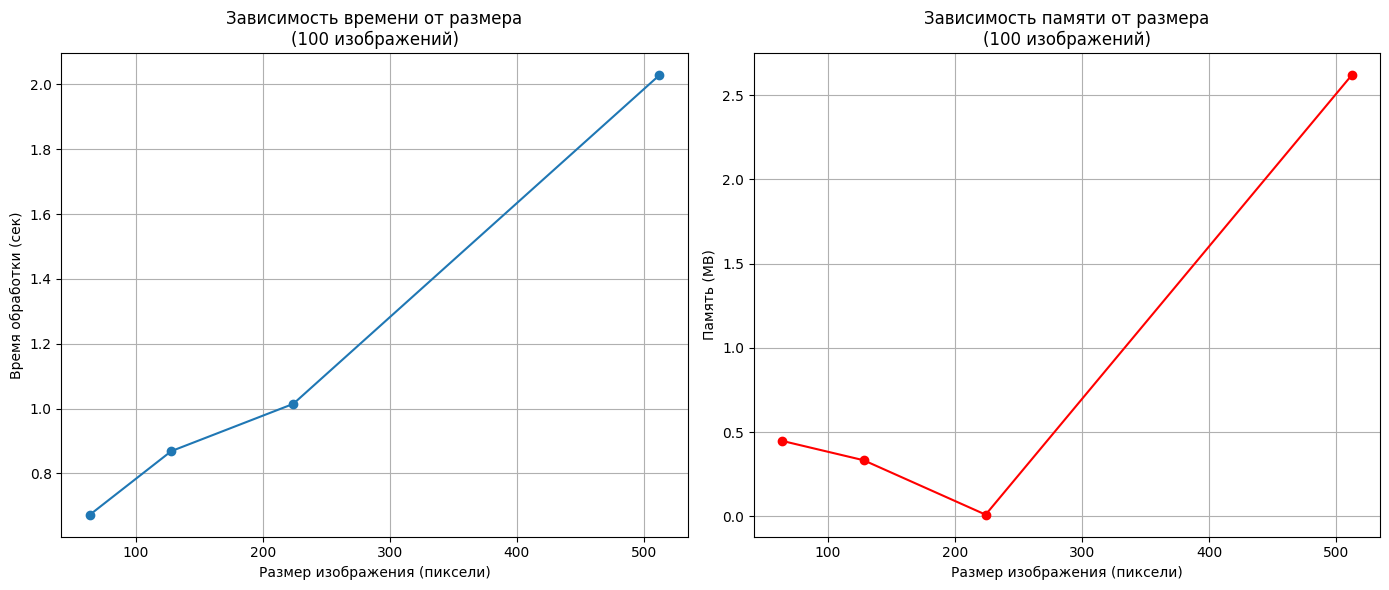


Итоговые результаты:
Размер	Время(сек)	Память(MB)
64x64	0.67		0.45
128x128	0.87		0.33
224x224	1.01		0.01
512x512	2.03		2.62


In [6]:
import psutil
from tqdm import tqdm
import time

# 1. Настройки эксперимента
sizes = [64, 128, 224, 512]  # Тестируемые размеры
num_images = 100              # Количество изображений для обработки
repeats = 3                   # Количество повторений для усреднения

# 2. Пайплайн аугментаций (одинаковый для всех размеров)
aug_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

# 3. Функция для измерения памяти
def get_memory_usage():
    return psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)  # в MB

# 4. Проведение эксперимента
results = []
dataset_path = "ваш/путь/к/данным"  # Укажите ваш путь

for size in sizes:
    print(f"\n=== Размер {size}x{size} ===")
    
    # Создаем датасет с текущим размером
    root = os.path.abspath("E:/vscode files/lab5/data/train")
    dataset = CustomImageDataset(root, transform=None, target_size=(size,size))
    
    time_results = []
    mem_results = []
    
    for _ in range(repeats):
        # Подготовка
        mem_before = get_memory_usage()
        start_time = time.time()
        
        # Обработка изображений
        for i in tqdm(range(num_images), desc=f"Обработка {size}x{size}"):
            idx = i % len(dataset)  # Циклически используем изображения
            img, _ = dataset[idx]
            
            # Применяем аугментации
            _ = aug_pipeline(img)
        
        # Замер показателей
        duration = time.time() - start_time
        mem_used = get_memory_usage() - mem_before
        
        time_results.append(duration)
        mem_results.append(mem_used)
    
    # Усредняем результаты
    avg_time = np.mean(time_results)
    avg_mem = np.mean(mem_results)
    
    results.append({
        'size': size,
        'time': avg_time,
        'memory': avg_mem
    })
    
    print(f"Среднее время: {avg_time:.2f} сек")
    print(f"Средняя память: {avg_mem:.2f} MB")

# 5. Визуализация результатов
plt.figure(figsize=(14, 6))

# График времени
plt.subplot(1, 2, 1)
plt.plot([r['size'] for r in results], [r['time'] for r in results], 'o-')
plt.xlabel('Размер изображения (пиксели)')
plt.ylabel('Время обработки (сек)')
plt.title('Зависимость времени от размера\n(100 изображений)')
plt.grid(True)

# График памяти
plt.subplot(1, 2, 2)
plt.plot([r['size'] for r in results], [r['memory'] for r in results], 'o-r')
plt.xlabel('Размер изображения (пиксели)')
plt.ylabel('Память (MB)')
plt.title('Зависимость памяти от размера\n(100 изображений)')
plt.grid(True)

plt.tight_layout()
plt.savefig('size_experiment_results.png', dpi=150, bbox_inches='tight')
plt.show()

# 6. Вывод таблицы результатов
print("\nИтоговые результаты:")
print("Размер\tВремя(сек)\tПамять(MB)")
for r in results:
    print(f"{r['size']}x{r['size']}\t{r['time']:.2f}\t\t{r['memory']:.2f}")